<a href="https://colab.research.google.com/github/groda/big_data/blob/master/Apache_Sedona_with_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90" alt="Logo Big Data for Beginners"></div></a>
# Apache Sedona with PySpark

Apache Sedona™ is

> *a cluster computing system for processing large-scale spatial data. Sedona extends existing cluster computing systems, such as Apache Spark, Apache Flink, and Snowflake, with a set of out-of-the-box distributed Spatial Datasets and Spatial SQL that efficiently load, process, and analyze large-scale spatial data across machines.* ([https://sedona.apache.org/](https://sedona.apache.org/))

To execute a basic Sedona demonstration using PySpark on Google Colab, we made a few minor adjustments. The Sedona notebook starts below at [Apache Sedona Core demo](#scrollTo=Apache_Sedona_Core_demo).



## Install Apache Sedona and PySpark

To start with, we are going to install PySpark with Sedona following the instructions at: https://sedona.apache.org/latest-snapshot/setup/install-python/ but first we need to downgrade `shapely` because the version 2.0.2 that comes with Google Colab does not play well with the current version of Apache Sedona (see https://shapely.readthedocs.io/en/stable/migration.html).

### Downgrade Shapely to version 1.7.1

We need to install install any version of `shapely>=1.7.0` but smaller than `2.0`. We picked `1.7.1` because with 1.7.0 we got the error

    geopandas 0.13.2 requires shapely>=1.7.1, but you have shapely 1.7.0 which is incompatible.

Explanation for `pip -I`:

- [`-I, --ignore-installed`](https://pip.pypa.io/en/stable/cli/pip_install/#cmdoption-I)
> Ignore the installed packages, overwriting them. This can break your system if the existing package is of a different version or was installed with a different package manager!







In [1]:
!pip install -I shapely==1.7.1

  Using cached Shapely-1.7.1-cp310-cp310-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


### Install Geopandas

This step is only needed outside of Colab because on Google Colab `geopandas` is available by default.

In [2]:
!pip install geopandas==0.13.2

### Install Apache Sedona and PySpark

We can now install Apache Sedona together with PySpark (and Spark).

In [3]:
!pip install apache-sedona[spark]

In [4]:
%env SPARK_HOME = "/usr/local/lib/python3.10/dist-packages/pyspark"

env: SPARK_HOME="/usr/local/lib/python3.10/dist-packages/pyspark"


In [5]:
%env PYTHONPATH = /usr/local/lib/python3.10/dist-packages/pyspark/python

env: PYTHONPATH=/usr/local/lib/python3.10/dist-packages/pyspark/python


In [6]:
!pip info pyspark

ERROR: unknown command "info"


## Setup environment variables

We need to set two environment variables:

- `SPARK_HOME`
- `PYTHONPATH`

Once we have set `SPARK_HOME`, the variable `PYTHONPATH` is `$SPARK_HOME/python`.

### Find Spark home

There's an utility to find Spark home and I always forget how it's called exactly, what I remember is that it contains `"find"` and `"spark"`. Let us search for it:

In [7]:
!find / -name "*find*spark*"

/usr/local/bin/find_spark_home.py
/usr/local/bin/__pycache__/find_spark_home.cpython-310.pyc
/usr/local/bin/find-spark-home.cmd
/usr/local/bin/find-spark-home
/usr/local/lib/python3.10/dist-packages/pyspark/bin/find-spark-home.cmd
/usr/local/lib/python3.10/dist-packages/pyspark/bin/find-spark-home
/usr/local/lib/python3.10/dist-packages/pyspark/find_spark_home.py
/usr/local/lib/python3.10/dist-packages/pyspark/__pycache__/find_spark_home.cpython-310.pyc
find: ‘/proc/61/task/61/net’: Invalid argument
find: ‘/proc/61/net’: Invalid argument


The script `/usr/local/bin/find_spark_home.py` is successful at finding Spark's home.

#### Set `SPARK_HOME`

In [8]:
import sys
import os
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  output = !python /usr/local/bin/find_spark_home.py
else:
  output = !find / -name "pyspark" -type d 2>/dev/null|head -1
# Store the output using %store
%store output
# get rid of extra quotation marks
os.environ['SPARK_HOME'] = output[0].replace('"', '')

Stored 'output' (SList)


In [9]:
!pip show pyspark

Name: pyspark
Version: 3.5.0
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: py4j
Required-by: 


Verify that the correct `SPARK_HOME` has been set.

In [10]:
os.environ['SPARK_HOME']

'/usr/local/lib/python3.10/dist-packages/pyspark'

In [11]:
%env SPARK_HOME

'/usr/local/lib/python3.10/dist-packages/pyspark'

#### Set `PYTHONPATH`

In [12]:
os.environ['PYTHONPATH'] = os.environ['SPARK_HOME'] + '/python'

Check

In [13]:
%env PYTHONPATH

'/usr/local/lib/python3.10/dist-packages/pyspark/python'

## Download data

In order to run, the Sedona notebook expects to find some specific files in the local folder `data`. Let us populate `data` with the files from the Sedona Github repository.

In [14]:
%%bash
# it would be more efficient to just download the "data" folder and not the whole repo
[ -d sedona ] || git clone https://github.com/apache/sedona.git

cp -r sedona/binder/data ./

Verify the presence of data in the designated `data` folder.

In [15]:
!ls data

arealm-small.csv	 gis_osm_pois_free_1.shp	 primaryroads-polygon.csv
county_small.tsv	 gis_osm_pois_free_1.shx	 raster
county_small_wkb.tsv	 ne_50m_admin_0_countries_lakes  testpoint.csv
gis_osm_pois_free_1.cpg  ne_50m_airports		 testPolygon.json
gis_osm_pois_free_1.dbf  polygon			 zcta510-small.csv
gis_osm_pois_free_1.prj  primaryroads-linestring.csv


# Apache Sedona Core demo

The notebook is available at the following link:
https://github.com/apache/sedona/blob/master/binder/ApacheSedonaCore.ipynb


```
Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at
  http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.
```

In [16]:
from pyspark.sql import SparkSession
from pyspark import StorageLevel
import geopandas as gpd
import pandas as pd
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import LongType
from shapely.geometry import Point
from shapely.geometry import Polygon

from sedona.spark import *
from sedona.core.geom.envelope import Envelope


Skipping SedonaKepler import, verify if keplergl is installed
Skipping SedonaPyDeck import, verify if pydeck is installed


In [17]:
config = SedonaContext.builder() .\
    config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-3.4_2.12:1.5.1,'
           'org.datasyslab:geotools-wrapper:1.5.1-28.2,'
           'uk.co.gresearch.spark:spark-extension_2.12:2.11.0-3.4'). \
    config('spark.jars.repositories', 'https://artifacts.unidata.ucar.edu/repository/unidata-all'). \
    getOrCreate()

sedona = SedonaContext.create(config)

In [18]:
sc = sedona.sparkContext

# Create SpatialRDD

## Reading to PointRDD from CSV file

Suppose we want load the CSV file into Apache Sedona PointRDD
```
testattribute0,-88.331492,32.324142,testattribute1,testattribute2
testattribute0,-88.175933,32.360763,testattribute1,testattribute2
testattribute0,-88.388954,32.357073,testattribute1,testattribute2
testattribute0,-88.221102,32.35078,testattribute1,testattribute2
testattribute0,-88.323995,32.950671,testattribute1,testattribute2
testattribute0,-88.231077,32.700812,testattribute1,testattribute2
```

In [19]:
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, True, 10)

In [20]:
## Getting approximate total count
point_rdd.approximateTotalCount

3000

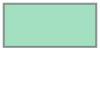

In [21]:
# getting boundary for PointRDD or any other SpatialRDD, it returns Enelope object which inherits from
# shapely.geometry.Polygon
point_rdd.boundary()

In [22]:
# To run analyze please use function analyze
point_rdd.analyze()

True

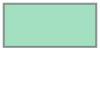

In [23]:
# Finding boundary envelope for PointRDD or any other SpatialRDD, it returns Enelope object which inherits from
# shapely.geometry.Polygon
point_rdd.boundaryEnvelope

In [24]:
# Calculate number of records without duplicates
point_rdd.countWithoutDuplicates()

2996

In [25]:
# Getting source epsg code
point_rdd.getSourceEpsgCode()

''

In [26]:
# Getting target epsg code
point_rdd.getTargetEpsgCode()

''

In [27]:
# Spatial partitioning data
point_rdd.spatialPartitioning(GridType.KDBTREE)

True

## Operations on RawSpatialRDD

rawSpatialRDD method returns RDD which consists of GeoData objects which has 2 attributes
<li> geom: shapely.geometry.BaseGeometry </li>
<li> userData: str </li>

You can use any operations on those objects and spread across machines

In [28]:
# take firs element
point_rdd.rawSpatialRDD.take(1)

[Geometry: Point userData: testattribute0	testattribute1	testattribute2]

In [29]:
# collect to Python list
point_rdd.rawSpatialRDD.collect()[:5]

[Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2]

In [30]:
# apply map functions, for example distance to Point(52 21)
point_rdd.rawSpatialRDD.map(lambda x: x.geom.distance(Point(21, 52))).take(5)

[111.08786851399313,
 110.92828303170774,
 111.1385974283527,
 110.97450594034112,
 110.97122518072091]

## Transforming to GeoPandas

## Loaded data can be transformed to GeoPandas DataFrame in a few ways

### Directly from RDD

In [31]:
point_rdd_to_geo = point_rdd.rawSpatialRDD.map(lambda x: [x.geom, *x.getUserData().split("\t")])

In [32]:
point_gdf = gpd.GeoDataFrame(
    point_rdd_to_geo.collect(), columns=["geom", "attr1", "attr2", "attr3"], geometry="geom"
)

In [33]:
point_gdf[:5]

,geom,attr1,attr2,attr3
0,POINT (-88.33149 32.32414),testattribute0,testattribute1,testattribute2
1,POINT (-88.17593 32.36076),testattribute0,testattribute1,testattribute2
2,POINT (-88.38895 32.35707),testattribute0,testattribute1,testattribute2
3,POINT (-88.22110 32.35078),testattribute0,testattribute1,testattribute2
4,POINT (-88.32399 32.95067),testattribute0,testattribute1,testattribute2


### Using Adapter

In [34]:
# Adapter allows you to convert geospatial data types introduced with sedona to other ones

In [35]:
spatial_df = Adapter.\
    toDf(point_rdd, ["attr1", "attr2", "attr3"], sedona).\
    createOrReplaceTempView("spatial_df")

spatial_gdf = sedona.sql("Select attr1, attr2, attr3, geometry as geom from spatial_df")

In [36]:
spatial_gdf.show(5, False)

+--------------+--------------+--------------+----------------------------+
|attr1         |attr2         |attr3         |geom                        |
+--------------+--------------+--------------+----------------------------+
|testattribute0|testattribute1|testattribute2|POINT (-88.331492 32.324142)|
|testattribute0|testattribute1|testattribute2|POINT (-88.175933 32.360763)|
|testattribute0|testattribute1|testattribute2|POINT (-88.388954 32.357073)|
|testattribute0|testattribute1|testattribute2|POINT (-88.221102 32.35078) |
|testattribute0|testattribute1|testattribute2|POINT (-88.323995 32.950671)|
+--------------+--------------+--------------+----------------------------+
only showing top 5 rows



In [37]:
gpd.GeoDataFrame(spatial_gdf.toPandas(), geometry="geom")[:5]

,attr1,attr2,attr3,geom
0,testattribute0,testattribute1,testattribute2,POINT (-88.33149 32.32414)
1,testattribute0,testattribute1,testattribute2,POINT (-88.17593 32.36076)
2,testattribute0,testattribute1,testattribute2,POINT (-88.38895 32.35707)
3,testattribute0,testattribute1,testattribute2,POINT (-88.22110 32.35078)
4,testattribute0,testattribute1,testattribute2,POINT (-88.32399 32.95067)


### With DataFrame creation

In [38]:
schema = StructType(
    [
        StructField("geometry", GeometryType(), False),
        StructField("attr1", StringType(), False),
        StructField("attr2", StringType(), False),
        StructField("attr3", StringType(), False),
    ]
)

In [39]:
geo_df = sedona.createDataFrame(point_rdd_to_geo, schema, verifySchema=False)

In [40]:
gpd.GeoDataFrame(geo_df.toPandas(), geometry="geometry")[:5]

,geometry,attr1,attr2,attr3
0,POINT (-88.33149 32.32414),testattribute0,testattribute1,testattribute2
1,POINT (-88.17593 32.36076),testattribute0,testattribute1,testattribute2
2,POINT (-88.38895 32.35707),testattribute0,testattribute1,testattribute2
3,POINT (-88.22110 32.35078),testattribute0,testattribute1,testattribute2
4,POINT (-88.32399 32.95067),testattribute0,testattribute1,testattribute2


# Load Typed SpatialRDDs

Currently The library supports 5 typed SpatialRDDs:
<li> RectangleRDD </li>
<li> PointRDD </li>
<li> PolygonRDD </li>
<li> LineStringRDD </li>
<li> CircleRDD </li>

In [41]:
rectangle_rdd = RectangleRDD(sc, "data/zcta510-small.csv", FileDataSplitter.CSV, True, 11)
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, False, 11)
polygon_rdd = PolygonRDD(sc, "data/primaryroads-polygon.csv", FileDataSplitter.CSV, True, 11)
linestring_rdd = LineStringRDD(sc, "data/primaryroads-linestring.csv", FileDataSplitter.CSV, True)

In [42]:
rectangle_rdd.analyze()
point_rdd.analyze()
polygon_rdd.analyze()
linestring_rdd.analyze()

True

# Spatial Partitioning

Apache Sedona spatial partitioning method can significantly speed up the join query. Three spatial partitioning methods are available: KDB-Tree, Quad-Tree and R-Tree. Two SpatialRDD must be partitioned by the same way.

In [43]:
point_rdd.spatialPartitioning(GridType.KDBTREE)

True

# Create Index

Apache Sedona provides two types of spatial indexes, Quad-Tree and R-Tree. Once you specify an index type, Apache Sedona will build a local tree index on each of the SpatialRDD partition.

In [44]:
point_rdd.buildIndex(IndexType.RTREE, True)

# SpatialJoin

Spatial join is operation which combines data based on spatial relations like:
<li> intersects </li>
<li> touches </li>
<li> within </li>
<li> etc </li>

To Use Spatial Join in GeoPyspark library please use JoinQuery object, which has implemented below methods:
```python
SpatialJoinQuery(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

DistanceJoinQuery(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

spatialJoin(queryWindowRDD: SpatialRDD, objectRDD: SpatialRDD, joinParams: JoinParams) -> RDD

DistanceJoinQueryFlat(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

SpatialJoinQueryFlat(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

```

## Example SpatialJoinQueryFlat PointRDD with RectangleRDD

In [45]:
# partitioning the data
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())
# building an index
point_rdd.buildIndex(IndexType.RTREE, True)
# Perform Spatial Join Query
result = JoinQuery.SpatialJoinQueryFlat(point_rdd, rectangle_rdd, False, True)

As result we will get RDD[GeoData, GeoData]
It can be used like any other Python RDD. You can use map, take, collect and other functions  

In [46]:
result

MapPartitionsRDD[63] at map at FlatPairRddConverter.scala:30

In [47]:
result.take(2)

[[Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ]]

In [48]:
result.collect()[:3]

[[Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ]]

In [49]:
# getting distance using SpatialObjects
result.map(lambda x: x[0].geom.distance(x[1].geom)).take(5)

[0.0, 0.0, 0.0, 0.0, 0.0]

In [50]:
# getting area of polygon data
result.map(lambda x: x[0].geom.area).take(5)

[0.026651558685001447,
 0.026651558685001447,
 0.026651558685001447,
 0.026651558685001447,
 0.026651558685001447]

In [51]:
# Base on result you can create DataFrame object, using map function and build DataFrame from RDD

In [52]:
schema = StructType(
    [
        StructField("geom_left", GeometryType(), False),
        StructField("geom_right", GeometryType(), False)
    ]
)

In [53]:
# Set verifySchema to False
spatial_join_result = result.map(lambda x: [x[0].geom, x[1].geom])
sedona.createDataFrame(spatial_join_result, schema, verifySchema=False).show(5, True)

+--------------------+--------------------+
|           geom_left|          geom_right|
+--------------------+--------------------+
|POLYGON ((-87.229...|POINT (-87.105455...|
|POLYGON ((-87.229...|POINT (-87.10534 ...|
|POLYGON ((-87.229...|POINT (-87.160372...|
|POLYGON ((-87.229...|POINT (-87.204033...|
|POLYGON ((-87.229...|POINT (-87.204299...|
+--------------------+--------------------+
only showing top 5 rows



In [54]:
# Above code produces DataFrame with geometry Data type

In [55]:
sedona.createDataFrame(spatial_join_result, schema, verifySchema=False).printSchema()

root
 |-- geom_left: geometry (nullable = false)
 |-- geom_right: geometry (nullable = false)



We can create DataFrame object from Spatial Pair RDD using Adapter object as follows

In [56]:
Adapter.toDf(result, ["attr1"], ["attr2"], sedona).show(5, True)

+--------------------+-----+--------------------+-----+
|              geom_1|attr1|              geom_2|attr2|
+--------------------+-----+--------------------+-----+
|POLYGON ((-87.229...|     |POINT (-87.105455...|     |
|POLYGON ((-87.229...|     |POINT (-87.10534 ...|     |
|POLYGON ((-87.229...|     |POINT (-87.160372...|     |
|POLYGON ((-87.229...|     |POINT (-87.204033...|     |
|POLYGON ((-87.229...|     |POINT (-87.204299...|     |
+--------------------+-----+--------------------+-----+
only showing top 5 rows



This also produce DataFrame with geometry DataType

In [57]:
Adapter.toDf(result, ["attr1"], ["attr2"], sedona).printSchema()

root
 |-- geom_1: geometry (nullable = true)
 |-- attr1: string (nullable = true)
 |-- geom_2: geometry (nullable = true)
 |-- attr2: string (nullable = true)



We can create RDD which will be of type RDD[GeoData, List[GeoData]]
We can for example calculate number of Points within some polygon data

To do that we can use code specified below

In [58]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())

In [59]:
spatial_join_result_non_flat = JoinQuery.SpatialJoinQuery(point_rdd, rectangle_rdd, False, True)

In [60]:
# number of point for each polygon
number_of_points = spatial_join_result_non_flat.map(lambda x: [x[0].geom, x[1].__len__()])

In [61]:
schema = StructType([
    StructField("geometry", GeometryType(), False),
    StructField("number_of_points", LongType(), False)
])

In [62]:
sedona.createDataFrame(number_of_points, schema, verifySchema=False).show()

+--------------------+----------------+
|            geometry|number_of_points|
+--------------------+----------------+
|POLYGON ((-87.114...|              15|
|POLYGON ((-87.082...|              12|
|POLYGON ((-86.697...|               1|
|POLYGON ((-87.285...|              26|
|POLYGON ((-87.105...|              15|
|POLYGON ((-86.816...|               6|
|POLYGON ((-87.229...|               7|
|POLYGON ((-87.092...|               5|
|POLYGON ((-86.749...|               4|
|POLYGON ((-86.860...|              12|
+--------------------+----------------+



# KNNQuery

Spatial KNNQuery is operation which help us find answer which k number of geometries lays closest to other geometry.

For Example:
    5 closest Shops to your home. To use Spatial KNNQuery please use object
<b> KNNQuery </b> which has one method:
```python
SpatialKnnQuery(spatialRDD: SpatialRDD, originalQueryPoint: BaseGeometry, k: int,  useIndex: bool)-> List[GeoData]
```

### Finds 5 closest points from PointRDD to given Point

In [63]:
result = KNNQuery.SpatialKnnQuery(point_rdd, Point(-84.01, 34.01), 5, False)

In [64]:
result

[Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ]

As Reference geometry you can also use Polygon or LineString object

In [65]:
polygon = Polygon(
    [(-84.237756, 33.904859), (-84.237756, 34.090426),
     (-83.833011, 34.090426), (-83.833011, 33.904859),
     (-84.237756, 33.904859)
    ])
polygons_nearby = KNNQuery.SpatialKnnQuery(polygon_rdd, polygon, 5, False)

In [66]:
polygons_nearby

[Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ]

In [67]:
polygons_nearby[0].geom.wkt

'POLYGON ((-83.993559 34.087259, -83.993559 34.131247, -83.959903 34.131247, -83.959903 34.087259, -83.993559 34.087259))'

# RangeQuery

A spatial range query takes as input a range query window and an SpatialRDD and returns all geometries that intersect / are fully covered by the query window.
RangeQuery has one method:

```python
SpatialRangeQuery(self, spatialRDD: SpatialRDD, rangeQueryWindow: BaseGeometry, considerBoundaryIntersection: bool, usingIndex: bool) -> RDD
```

In [68]:
from sedona.core.geom.envelope import Envelope

In [69]:
query_envelope = Envelope(-85.01, -60.01, 34.01, 50.01)

result_range_query = RangeQuery.SpatialRangeQuery(linestring_rdd, query_envelope, False, False)

In [70]:
result_range_query

MapPartitionsRDD[127] at map at GeometryRddConverter.scala:30

In [71]:
result_range_query.take(6)

[Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ]

In [72]:
# Creating DataFrame from result

In [73]:
schema = StructType([StructField("geometry", GeometryType(), False)])

In [74]:
sedona.createDataFrame(
    result_range_query.map(lambda x: [x.geom]),
    schema,
    verifySchema=False
).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|LINESTRING (-72.1...|
|LINESTRING (-72.4...|
|LINESTRING (-72.4...|
|LINESTRING (-73.4...|
|LINESTRING (-73.6...|
+--------------------+
only showing top 5 rows



# Load From other Formats

GeoPyspark allows to load the data from other Data formats like:
<li> GeoJSON </li>
<li> Shapefile </li>
<li> WKB </li>
<li> WKT </li>

In [75]:
## ShapeFile - load to SpatialRDD

In [76]:
shape_rdd = ShapefileReader.readToGeometryRDD(sc, "data/polygon")

In [77]:
shape_rdd

In [78]:
Adapter.toDf(shape_rdd, sedona).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|MULTIPOLYGON (((1...|
|MULTIPOLYGON (((-...|
|MULTIPOLYGON (((1...|
|POLYGON ((118.362...|
|MULTIPOLYGON (((-...|
+--------------------+
only showing top 5 rows



In [79]:
## GeoJSON - load to SpatialRDD

```
{ "type": "Feature", "properties": { "STATEFP": "01", "COUNTYFP": "077", "TRACTCE": "011501", "BLKGRPCE": "5", "AFFGEOID": "1500000US010770115015", "GEOID": "010770115015", "NAME": "5", "LSAD": "BG", "ALAND": 6844991, "AWATER": 32636 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -87.621765, 34.873444 ], [ -87.617535, 34.873369 ], [ -87.6123, 34.873337 ], [ -87.604049, 34.873303 ], [ -87.604033, 34.872316 ], [ -87.60415, 34.867502 ], [ -87.604218, 34.865687 ], [ -87.604409, 34.858537 ], [ -87.604018, 34.851336 ], [ -87.603716, 34.844829 ], [ -87.603696, 34.844307 ], [ -87.603673, 34.841884 ], [ -87.60372, 34.841003 ], [ -87.603879, 34.838423 ], [ -87.603888, 34.837682 ], [ -87.603889, 34.83763 ], [ -87.613127, 34.833938 ], [ -87.616451, 34.832699 ], [ -87.621041, 34.831431 ], [ -87.621056, 34.831526 ], [ -87.62112, 34.831925 ], [ -87.621603, 34.8352 ], [ -87.62158, 34.836087 ], [ -87.621383, 34.84329 ], [ -87.621359, 34.844438 ], [ -87.62129, 34.846387 ], [ -87.62119, 34.85053 ], [ -87.62144, 34.865379 ], [ -87.621765, 34.873444 ] ] ] } },
```

In [80]:
geo_json_rdd = GeoJsonReader.readToGeometryRDD(sc, "data/testPolygon.json")

In [81]:
geo_json_rdd

In [82]:
Adapter.toDf(geo_json_rdd, sedona).drop("AWATER").show(5, True)

+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|            geometry|STATEFP|COUNTYFP|TRACTCE|BLKGRPCE|            AFFGEOID|       GEOID|NAME|LSAD|   ALAND|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|POLYGON ((-87.621...|     01|     077| 011501|       5|1500000US01077011...|010770115015|   5|  BG| 6844991|
|POLYGON ((-85.719...|     01|     045| 021102|       4|1500000US01045021...|010450211024|   4|  BG|11360854|
|POLYGON ((-86.000...|     01|     055| 001300|       3|1500000US01055001...|010550013003|   3|  BG| 1378742|
|POLYGON ((-86.574...|     01|     089| 001700|       2|1500000US01089001...|010890017002|   2|  BG| 1040641|
|POLYGON ((-85.382...|     01|     069| 041400|       1|1500000US01069041...|010690414001|   1|  BG| 8243574|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
only showi

In [83]:
## WKT - loading to SpatialRDD

In [84]:
wkt_rdd = WktReader.readToGeometryRDD(sc, "data/county_small.tsv", 0, True, False)

In [85]:
wkt_rdd

In [86]:
Adapter.toDf(wkt_rdd, sedona).printSchema()

root
 |-- geometry: geometry (nullable = true)



In [87]:
Adapter.toDf(wkt_rdd, sedona).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((-97.019...|
|POLYGON ((-123.43...|
|POLYGON ((-104.56...|
|POLYGON ((-96.910...|
|POLYGON ((-98.273...|
+--------------------+
only showing top 5 rows



In [88]:
## WKB - load to SpatialRDD

In [89]:
wkb_rdd = WkbReader.readToGeometryRDD(sc, "data/county_small_wkb.tsv", 0, True, False)

In [90]:
Adapter.toDf(wkb_rdd, sedona).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((-97.019...|
|POLYGON ((-123.43...|
|POLYGON ((-104.56...|
|POLYGON ((-96.910...|
|POLYGON ((-98.273...|
+--------------------+
only showing top 5 rows



## Converting RDD Spatial join result to DF directly, avoiding jvm python serde

In [91]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())
# building an index
point_rdd.buildIndex(IndexType.RTREE, True)
# Perform Spatial Join Query
result = JoinQueryRaw.SpatialJoinQueryFlat(point_rdd, rectangle_rdd, False, True)

In [92]:
# without passing column names, the result will contain only two geometries columns
geometry_df = Adapter.toDf(result, sedona)

In [93]:
geometry_df.printSchema()

root
 |-- leftgeometry: geometry (nullable = true)
 |-- rightgeometry: geometry (nullable = true)



In [94]:
geometry_df.show(5)

+--------------------+--------------------+
|        leftgeometry|       rightgeometry|
+--------------------+--------------------+
|POLYGON ((-87.229...|POINT (-87.105455...|
|POLYGON ((-87.229...|POINT (-87.10534 ...|
|POLYGON ((-87.229...|POINT (-87.160372...|
|POLYGON ((-87.229...|POINT (-87.204033...|
|POLYGON ((-87.229...|POINT (-87.204299...|
+--------------------+--------------------+
only showing top 5 rows



In [95]:
geometry_df.collect()[0]

Row(leftgeometry=<shapely.geometry.polygon.Polygon object at 0x7fb6e729ec50>, rightgeometry=<shapely.geometry.point.Point object at 0x7fb6e729dd20>)

## Passing column names

In [96]:
geometry_df = Adapter.toDf(result, ["left_user_data"], ["right_user_data"], sedona)

In [97]:
geometry_df.show(5)

+--------------------+--------------+--------------------+---------------+
|        leftgeometry|left_user_data|       rightgeometry|right_user_data|
+--------------------+--------------+--------------------+---------------+
|POLYGON ((-87.229...|              |POINT (-87.105455...|           null|
|POLYGON ((-87.229...|              |POINT (-87.10534 ...|           null|
|POLYGON ((-87.229...|              |POINT (-87.160372...|           null|
|POLYGON ((-87.229...|              |POINT (-87.204033...|           null|
|POLYGON ((-87.229...|              |POINT (-87.204299...|           null|
+--------------------+--------------+--------------------+---------------+
only showing top 5 rows



# Converting RDD Spatial join result to DF directly, avoiding jvm python serde

In [98]:
query_envelope = Envelope(-85.01, -60.01, 34.01, 50.01)

result_range_query = RangeQueryRaw.SpatialRangeQuery(linestring_rdd, query_envelope, False, False)

In [99]:
# converting to df
gdf = Adapter.toDf(result_range_query, sedona)

In [100]:
gdf.show(5)

+--------------------+
|            geometry|
+--------------------+
|LINESTRING (-72.1...|
|LINESTRING (-72.4...|
|LINESTRING (-72.4...|
|LINESTRING (-73.4...|
|LINESTRING (-73.6...|
+--------------------+
only showing top 5 rows



In [101]:
gdf.printSchema()

root
 |-- geometry: geometry (nullable = true)



In [102]:
# Passing column names
# converting to df
gdf_with_columns = Adapter.toDf(result_range_query, sedona, ["_c1"])

In [103]:
gdf_with_columns.show(5)

+--------------------+---+
|            geometry|_c1|
+--------------------+---+
|LINESTRING (-72.1...|   |
|LINESTRING (-72.4...|   |
|LINESTRING (-72.4...|   |
|LINESTRING (-73.4...|   |
|LINESTRING (-73.6...|   |
+--------------------+---+
only showing top 5 rows



In [104]:
gdf_with_columns.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- _c1: string (nullable = true)



# Summary

We have shown how to install Sedona with Pyspark and run a basic example (source: https://github.com/apache/sedona/blob/master/binder/ApacheSedonaCore.ipynb) on Google Colab.